# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [9]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [12]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

# Analysis for IMC

## Data reading

In [86]:
# parameters
_min_round_num = 1
_max_round_num = 4
_time_per_day = 1000000

In [207]:
def get_file_trades(day):
    if day == 4:
        cur_round = 5
    else:
        cur_round = min(day + 3, _max_round_num)
    fname = f"../data/round5/trades_round_{cur_round}_day_{day}_wn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    if day == 4:
        cur_round = 5
    else:
        cur_round = min(day + 3, _max_round_num)
    fname = f"../data/round{cur_round}/prices_round_{cur_round}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_symbol_trades(symbol, days):
    data = []
    for day in days:
        price_df = get_file_trades(day)
        price_df["day"] = day
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df
    


def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    price_df["mid"] = price_df["mid_price"]
    
    return price_df[["time", "symbol", "mid"]].copy()

In [208]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on="time")
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

In [209]:
def scatter_noise(x, y, xnoise=0.1, ynoise=0.1, s=0.1, label=None):
    xp = x + np.random.normal(scale=xnoise, size=len(x))
    yp = y + np.random.normal(scale=ynoise, size=len(y))
    
    plt.scatter(
        xp, yp, 
        s=s, 
        label=label,
    )

## Dolphin vs Gear - Leading indicator

fname ../data/round1/prices_round_1_day_-2.csv
fname ../data/round2/prices_round_2_day_-1.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round4/prices_round_4_day_1.csv
fname ../data/round4/prices_round_4_day_2.csv
fname ../data/round4/prices_round_4_day_3.csv
fname ../data/round5/prices_round_5_day_4.csv
fname ../data/round1/prices_round_1_day_-2.csv
fname ../data/round2/prices_round_2_day_-1.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round4/prices_round_4_day_1.csv
fname ../data/round4/prices_round_4_day_2.csv
fname ../data/round4/prices_round_4_day_3.csv
fname ../data/round5/prices_round_5_day_4.csv
model  
7.858 x + 7.54e+04


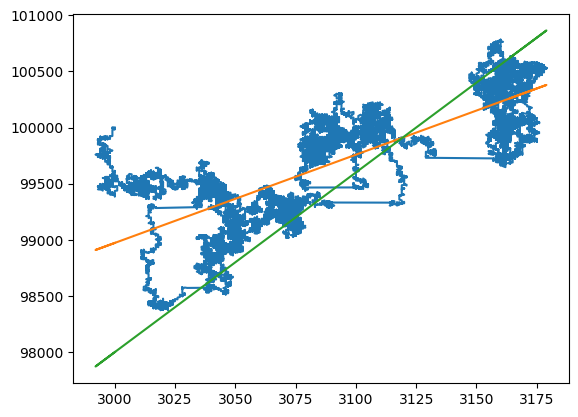

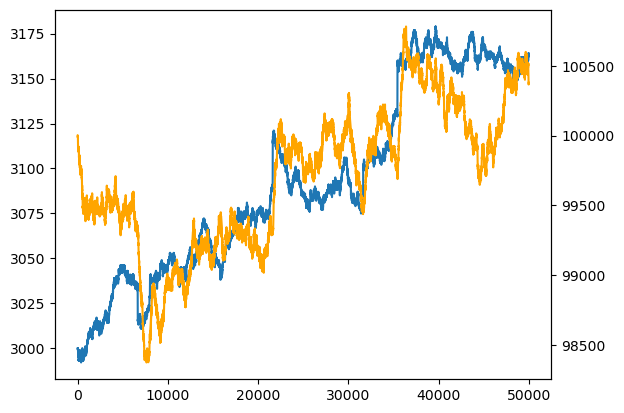

In [210]:
_day_range = [-2, -1, 0, 1, 2, 3, 4]

# get trade data for gear
# trade_df = get_symbol_trades("DIVING_GEAR", _day_range)

# get gear data
gear_price_df = get_symbol_prices("DIVING_GEAR", _day_range)
gear_df = get_whale_quotes(gear_price_df)

# get dol data
dol_df = get_all_mids(_day_range)
dol_df = dol_df[dol_df["symbol"] == "DOLPHIN_SIGHTINGS"].reset_index(drop=True)

# combine into single dataframe
pair_df = gear_df[["time"]].copy()
pair_df["gear"] = gear_df["mid_price"]
pair_df["dol"] = dol_df["mid"]

# fit linreg to data
model = np.poly1d(np.polyfit(pair_df["dol"], pair_df["gear"], deg=1))
print("model", model)
plt.plot(pair_df["dol"], pair_df["gear"])
plt.plot(pair_df["dol"], model(pair_df["dol"]))
plt.plot(pair_df["dol"], 16 * pair_df["dol"] + 50000)
plt.show()


# plot dol/gear over time
ax = plt.gca()
ax.plot(pair_df["dol"])

ax2 = ax.twinx()
ax2.plot(pair_df["gear"], color="orange")
plt.show()

# Current work

In [225]:
from sklearn.linear_model import LinearRegression, Lasso

In [232]:
np.logspace(1, 100, 10)

array([1.e+001, 1.e+012, 1.e+023, 1.e+034, 1.e+045, 1.e+056, 1.e+067,
       1.e+078, 1.e+089, 1.e+100])

In [240]:
np.logspace(1, np.log10(30000)).astype(int)

array([   10,    11,    13,    16,    19,    22,    26,    31,    36,
          43,    51,    60,    71,    83,    98,   115,   136,   160,
         189,   222,   262,   309,   364,   428,   504,   594,   699,
         824,   970,  1142,  1345,  1584,  1865,  2196,  2586,  3045,
        3586,  4222,  4972,  5854,  6893,  8117,  9558, 11255, 13252,
       15605, 18375, 21637, 25477, 30000])

In [296]:
data = []

for forecast_amt in np.arange(100, 2000+1, 100):
    plt.figure(figsize=(13, 20))
    
    for ind, past_shift in enumerate( np.arange(40000, 47000, 100).astype(int) ):

        # make copy of orig data
        df = pair_df.copy()

        df["dol_past_chg"] = df["dol"].diff(past_shift)
        df["gear_past_chg"] = df["gear"].diff(past_shift)

        # predict
        df["gear_chg"] = -1 * df["gear"].diff(-1 * forecast_amt)
        df = df.dropna()

        X = df[["dol_past_chg", "dol", "gear"]]
        y = df["gear_chg"]

        reg = Lasso(alpha=0.1).fit(X, y)
        r2 = reg.score(X, y)
#         print("coef", np.round(reg.coef_, 5), "int", np.round(reg.intercept_, 2))
#         print("r2", round(r2, 2))

        data += [{
            "forecast": forecast_amt,
            "past": past_shift,
            "m1": reg.coef_[0],
            "m2": reg.coef_[1],
            "b": reg.intercept_,
            "r2": r2,
        }]


        ypred = reg.predict(X)

#         plt.subplot(12, 3, ind + 1)
#         plt.plot(df.index, y, label="actual")
#         plt.plot(df.index, ypred, label="pred")
#         plt.title(f"past: {past_shift}, future: {forecast_amt}, r2: {round(r2, 2)}")
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

<Figure size 1300x2000 with 0 Axes>

In [312]:
data = []

forecast_amt = 600
past_shift = 43200
ind = 0

# make copy of orig data
df = pair_df.copy()

df["dol_past_chg"] = df["dol"].diff(past_shift)
df["gear_past_chg"] = df["gear"].diff(past_shift)

# predict
df["gear_chg"] = -1 * df["gear"].diff(-1 * forecast_amt)
df = df.dropna()

X = df[["dol_past_chg", "dol", "gear"]]
y = df["gear_chg"]

reg = Lasso(alpha=0.1).fit(X, y)
r2 = reg.score(X, y)
#         print("coef", np.round(reg.coef_, 5), "int", np.round(reg.intercept_, 2))
#         print("r2", round(r2, 2))

data += [{
    "forecast": forecast_amt,
    "past": past_shift,
    "m1": reg.coef_[0],
    "m2": reg.coef_[1],
    "b": reg.intercept_,
    "r2": r2,
}]


ypred = reg.predict(X)

#         plt.subplot(12, 3, ind + 1)
#         plt.plot(df.index, y, label="actual")
#         plt.plot(df.index, ypred, label="pred")
#         plt.title(f"past: {past_shift}, future: {forecast_amt}, r2: {round(r2, 2)}")
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

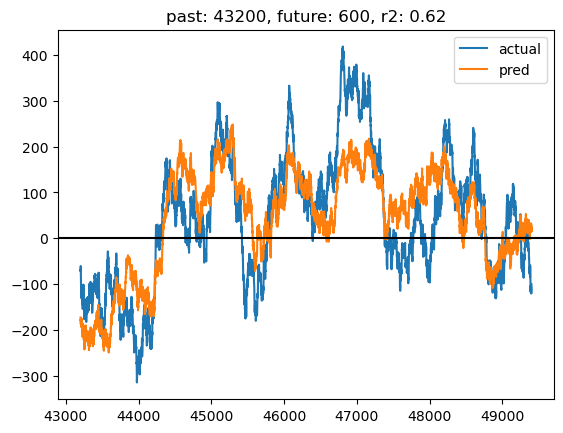

In [315]:
plt.plot(df.index, y, label="actual")
plt.plot(df.index, ypred, label="pred")
plt.axhline(y=0, color="black")
plt.title(f"past: {past_shift}, future: {forecast_amt}, r2: {round(r2, 2)}")
plt.legend()

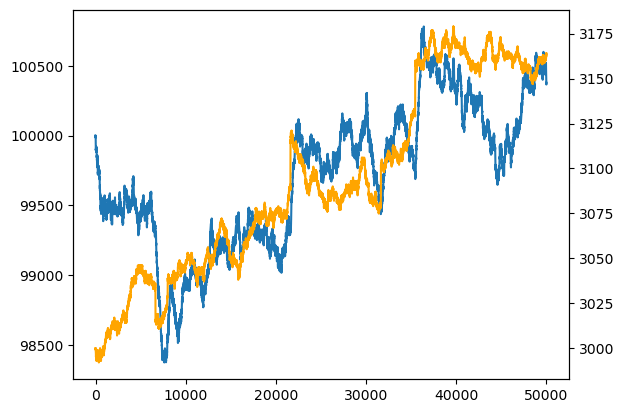

In [306]:
plt.gca().plot(pair_df.index, pair_df["gear"])
plt.gca().twinx().plot(pair_df.index, pair_df["dol"], color="orange")


In [298]:
res_df = pd.DataFrame(data)
grid_df = res_df.pivot(index="forecast", columns=["past"])["r2"]

In [299]:
import seaborn as sns

<AxesSubplot: xlabel='forecast', ylabel='past'>

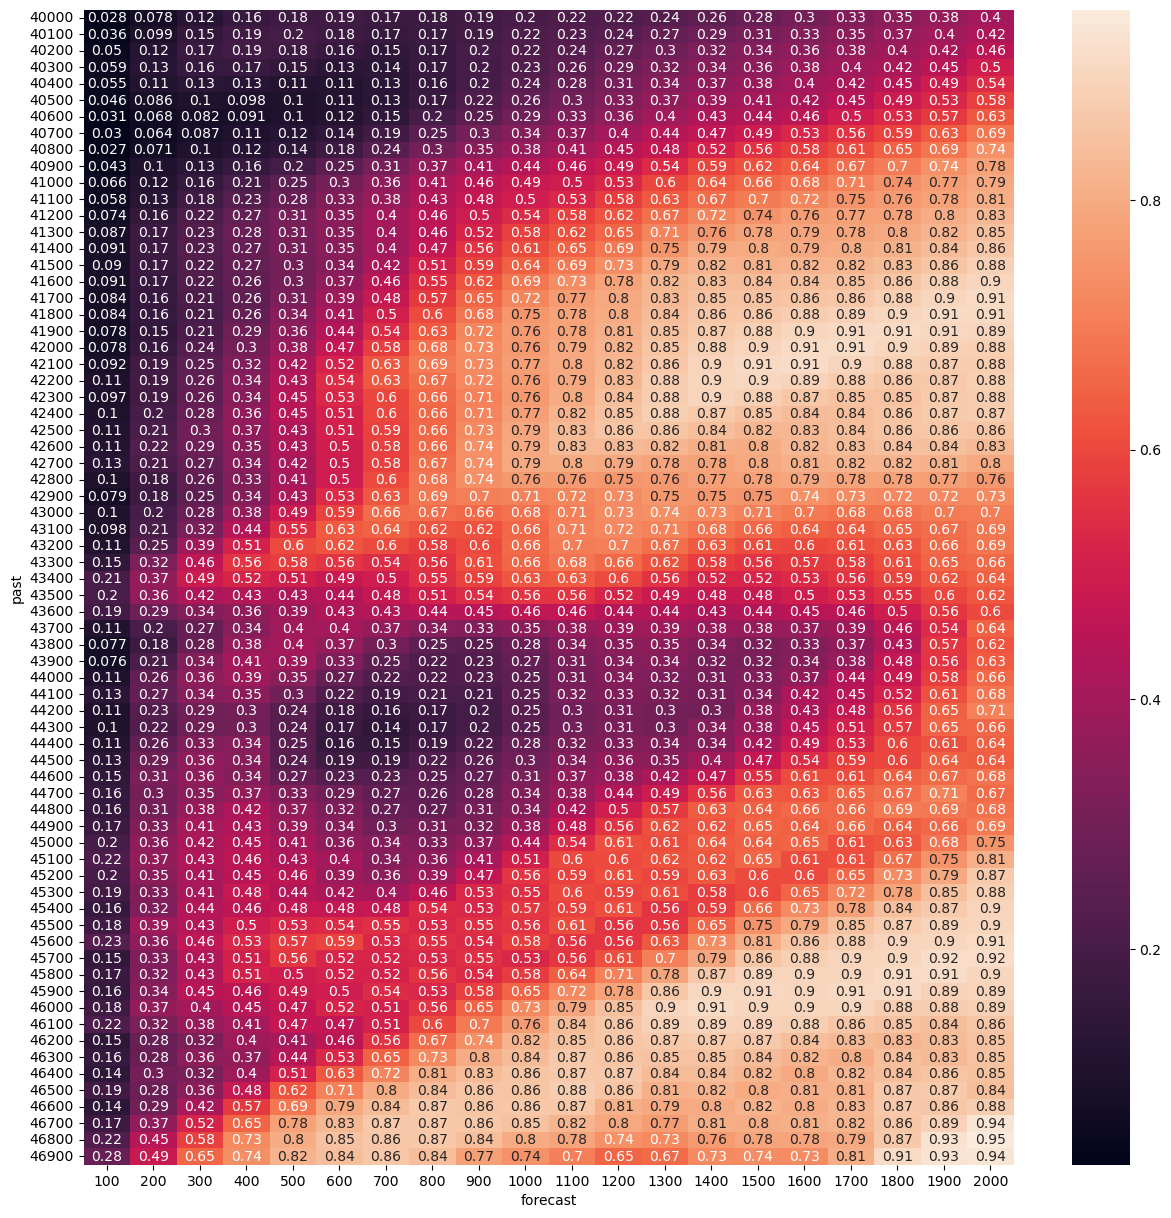

In [301]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.heatmap(grid_df.T, annot=True, ax=ax)

In [168]:
reg.score(X, y)

0.8445472317193894

In [148]:
df

,time,gear,dol,gear_next,dol_prev,gear_chg
100,2010000,99890.5,2994.0,99888.5,-6.0,-2.0
101,2010100,99888.5,2993.0,99882.5,-7.0,-6.0
102,2010200,99882.5,2993.0,99883.5,-6.0,1.0
103,2010300,99883.5,2993.0,99898.0,-6.0,14.5
104,2010400,99898.0,2993.0,99892.5,-6.0,-5.5
...,...,...,...,...,...,...
49994,6999400,100376.0,3163.0,100371.0,1.0,-5.0
49995,6999500,100371.0,3163.0,100375.0,1.0,4.0
49996,6999600,100375.0,3163.0,100367.0,1.0,-8.0
49997,6999700,100367.0,3163.0,100369.0,0.0,2.0


In [143]:
pair_df.dropna()

,time,gear,dol,gear_next,dol_prev
1000,2100000,99537.5,3000.0,99539.5,0.0
1001,2100100,99539.5,3000.0,99542.0,0.0
1002,2100200,99542.0,3000.0,99539.5,1.0
1003,2100300,99539.5,3000.0,99552.0,1.0
1004,2100400,99552.0,3001.0,99554.5,2.0
...,...,...,...,...,...
49994,6999400,100376.0,3163.0,100371.0,7.0
49995,6999500,100371.0,3163.0,100375.0,7.0
49996,6999600,100375.0,3163.0,100367.0,7.0
49997,6999700,100367.0,3163.0,100369.0,7.0


In [133]:
shifts = np.arange(100, 200, 100)

for shift in shifts:
    print(shift)

100


In [137]:
pair_df

,time,gear,dol,gear_next
0,2000000,100000.0,3000.0,100000.0
1,2000100,100000.0,3000.0,100002.0
2,2000200,100002.0,2999.0,100000.0
3,2000300,100000.0,2999.0,99994.5
4,2000400,99994.5,2999.0,99991.5
...,...,...,...,...
49995,6999500,100371.0,3163.0,100375.0
49996,6999600,100375.0,3163.0,100367.0
49997,6999700,100367.0,3163.0,100369.0
49998,6999800,100369.0,3164.0,100379.0


In [ ]:
pair_df

In [131]:
pair_df.shift(100)

,time,gear,dol
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
49995,6989500.0,100466.5,3162.0
49996,6989600.0,100466.5,3162.0
49997,6989700.0,100470.5,3163.0
49998,6989800.0,100478.5,3163.0


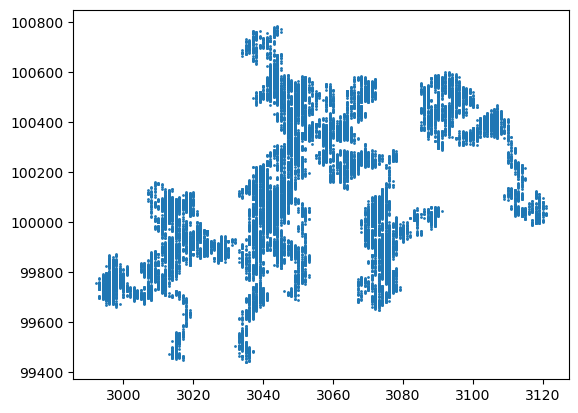

In [122]:
plt.scatter(pair_df["dol"].shift(25000), pair_df["gear"], s=1)

### dol / gear change histograms

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(221)
plt.hist(pair_df["dol"], bins=20)
plt.title("dol")

plt.subplot(222)
plt.hist(pair_df["gear"], bins=20)
plt.title("gear")

plt.subplot(223)
plt.hist(pair_df["dol"].diff(1), bins=100)
plt.title("dol change")

plt.subplot(224)
plt.hist(pair_df["gear"].diff(1), bins=20)
plt.title("gear change")

plt.tight_layout()
plt.show()

# print stats
print("dol stats")
display(pair_df["dol"].diff(1).describe().to_frame().T)
print("gear stats")

display(pair_df["gear"].diff(1).describe().to_frame().T)

#### dol/gear change filtered


In [36]:
pair_df["dol_change"] = pair_df["dol"].diff(1) 

Series([], dtype: float64)

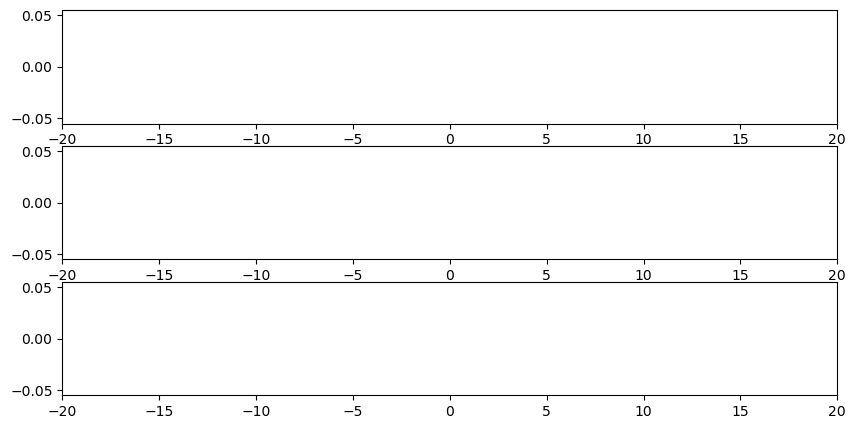

In [37]:
ups = pair_df["dol_change"] > 0
downs = pair_df["dol_change"] < 0
sames = pair_df["dol_change"] == 0

pair_df["dol_sign"] = np.sign(pair_df["dol_change"])
pair_df["gear_change"] = pair_df["gear"].diff(1)

plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.hist(pair_df["gear_change"][ups], bins=100)
plt.xlim(-20, 20)

plt.subplot(312)
plt.hist(pair_df["gear_change"][downs], bins=100)
plt.xlim(-20, 20)

plt.subplot(313)
plt.hist(pair_df["gear_change"][sames], bins=100)
plt.xlim(-20, 20)

pair_df.groupby("dol_sign")[["gear_change"]].describe()

### closer look into single event

In [18]:
change = pair_df["dol"].diff(25)
special = pair_df[change.abs() > 5].copy()
special["dol_change"] = change
display(special)

,time,gear,dol,dol_change,dol_sign,gear_change
3912,391200,99520.5,3034.0,6.0,1.0,-3.0
6641,664100,99283.0,3017.0,-17.0,-1.0,-8.5
6642,664200,99287.0,3017.0,-17.0,0.0,4.0
6643,664300,99286.5,3017.0,-16.0,0.0,-0.5
6644,664400,99288.0,3017.0,-16.0,0.0,1.5
...,...,...,...,...,...,...
23273,2327300,99880.0,3092.0,-6.0,-1.0,-3.0
23274,2327400,99885.0,3092.0,-6.0,0.0,5.0
23275,2327500,99882.0,3092.0,-6.0,0.0,-3.0
24176,2417600,99957.0,3095.0,-6.0,-1.0,6.0


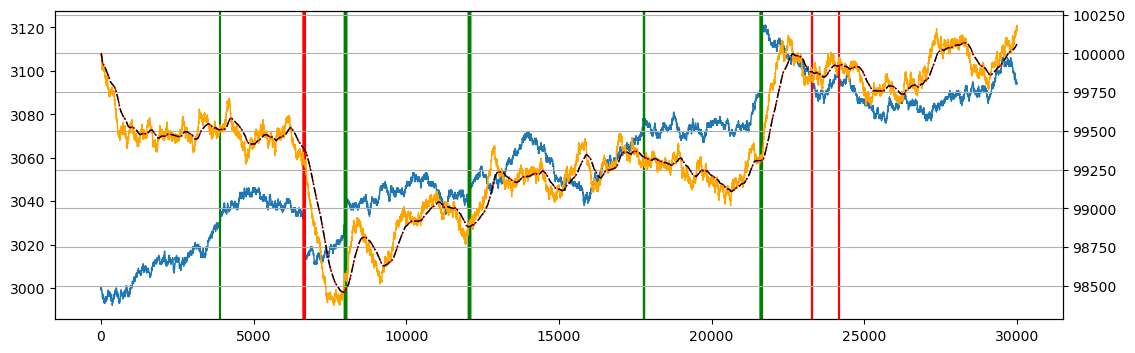

In [19]:
# all
plt.figure(figsize=(13, 4))
ax = plt.gca()
ax.plot(pair_df["dol"], linewidth=1)
# ax.plot(pair_df["dol"].ewm(span=200).mean(), linewidth=1, linestyle="--", marker=None, color="green")
ax2 = ax.twinx()
ax2.plot(pair_df["gear"], linewidth=1, color="orange")
ax2.plot(pair_df["gear"].ewm(span=500).mean(), linewidth=1, linestyle="--", marker=None, color="red")
ax2.plot(pair_df["gear"].ewm(span=500).mean(), linewidth=1, linestyle="-.", marker=None, color="black")

for x in special.index:
    if special.loc[x]["dol_change"] > 0:
        color = "green"
    else:
        color = "red"
    ax.axvline(x=x, color=color)

plt.grid()
plt.show()

In [20]:
pair_df["gear"]

0        100000.0
1        100000.0
2        100002.0
3        100000.0
4         99994.5
           ...   
29995    100174.5
29996    100171.0
29997    100179.5
29998    100182.0
29999    100179.5
Name: gear, Length: 30000, dtype: float64

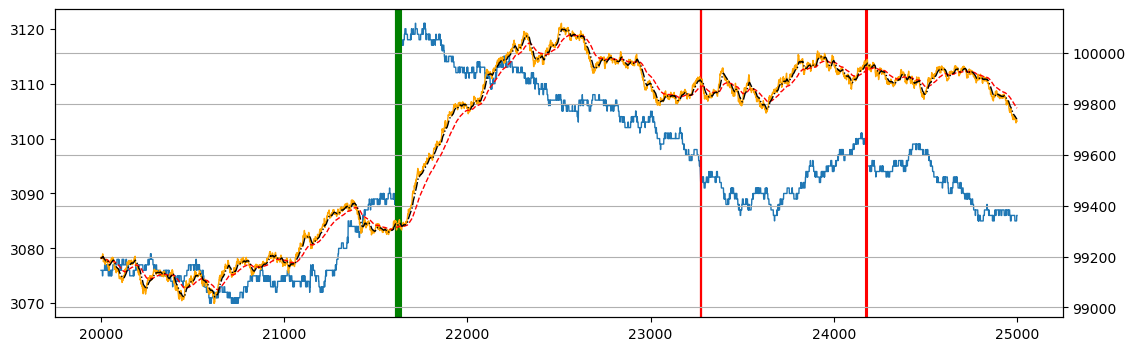

In [21]:
# closer look
df = pair_df.iloc[20000:25000]
# df = pair_df.iloc[5000:10000]
# all
plt.figure(figsize=(13, 4))
ax = plt.gca()
ax.plot(df["dol"], linewidth=1)
# ax.plot(pair_df["dol"].ewm(span=200).mean(), linewidth=1, linestyle="--", marker=None, color="green")
ax2 = ax.twinx()
ax2.plot(df["gear"], linewidth=1, color="orange")
ax2.plot(df["gear"].ewm(span=100).mean(), linewidth=1, linestyle="--", marker=None, color="red")
ax2.plot(df["gear"].ewm(span=21).mean(), linewidth=1, linestyle="-.", marker=None, color="black")

for x in special.index:
    if x not in df.index:
        continue
    if special.loc[x]["dol_change"] > 0:
        color = "green"
    else:
        color = "red"
    ax.axvline(x=x, color=color)

plt.grid()
plt.show()

### closer look into single event

In [22]:
pair_df[pair_df["dol"].diff(1).abs() > 5]

,time,gear,dol,dol_change,dol_sign,gear_change
6641,664100,99283.0,3017.0,-19.0,-1.0,-8.5
7997,799700,98573.0,3039.0,9.0,1.0,1.5
12057,1205700,98878.0,3046.0,8.0,1.0,-7.5
21611,2161100,99331.0,3114.0,26.0,1.0,-1.0


### Gear Change Moving Average

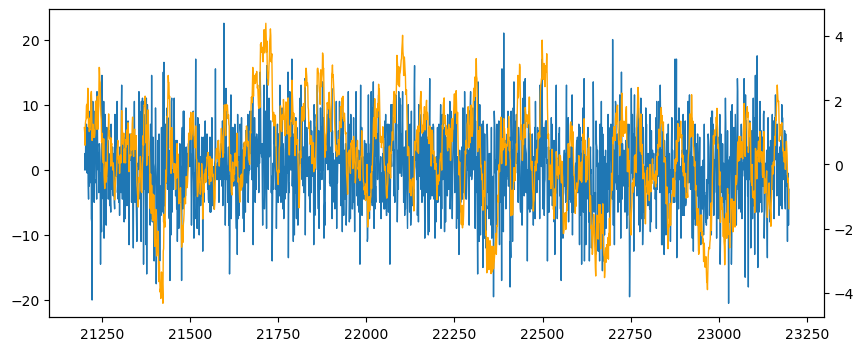

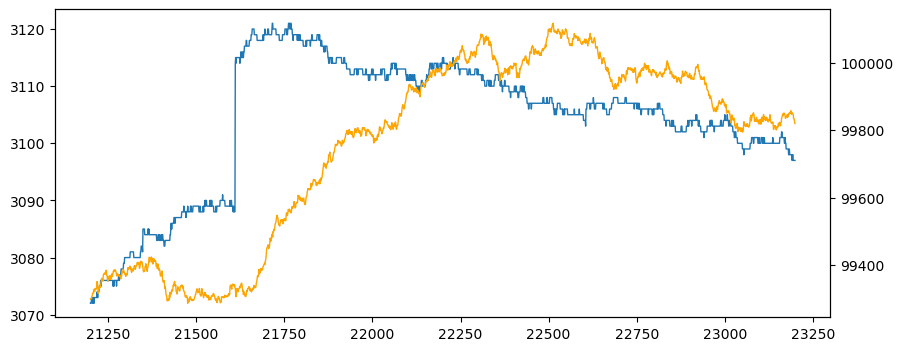

In [23]:
lb, offset = 21200, 2000
ub = lb + offset

df = pair_df.iloc[lb:ub]

diff = df["gear"].diff(1)
sma_diff = pair_df["gear"].diff(1).rolling(20).mean().iloc[lb:ub]

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(diff, linewidth=1)
ax.twinx().plot(sma_diff, linewidth=1, color="orange")
plt.show()

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(df["dol"], linewidth=1)
ax.twinx().plot(df["gear"], linewidth=1, color="orange")

### closer look into single event

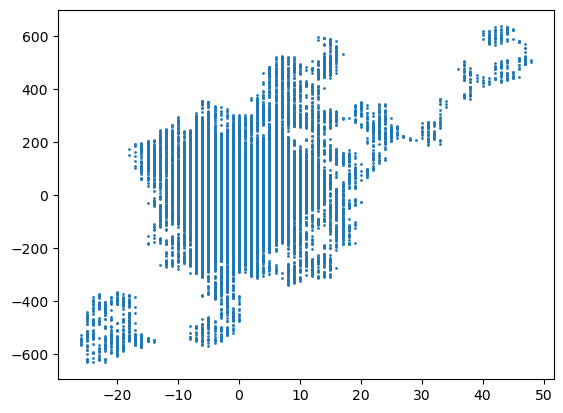

In [24]:
diff = 500
plt.scatter(pair_df["dol"].diff(diff), -1 * pair_df["gear"].diff(-diff), s=1)

### gear trade info

,time,gear,dol,dol_change,dol_sign,gear_change
7992,799200,98563.0,3028.0,0.0,0.0,-4.0
7993,799300,98575.0,3029.0,1.0,1.0,12.0
7994,799400,98575.0,3029.0,0.0,0.0,0.0
7995,799500,98575.0,3029.0,0.0,0.0,0.0
7996,799600,98571.5,3030.0,1.0,1.0,-3.5
7997,799700,98573.0,3039.0,9.0,1.0,1.5
7998,799800,98570.0,3039.0,0.0,0.0,-3.0
7999,799900,98564.5,3039.0,0.0,0.0,-5.5
8000,800000,98564.5,3039.0,0.0,0.0,0.0
8001,800100,98559.5,3039.0,0.0,0.0,-5.0


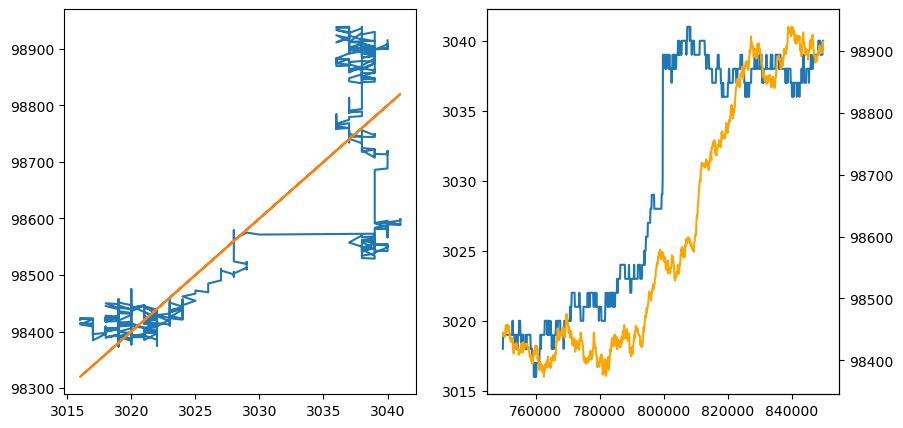

In [25]:
# plot single event

ind = 7997
df = pair_df.loc[ind-500:ind+500]

display(pair_df.loc[ind-5:ind+5])

plt.figure(figsize=(10, 5))

plt.subplot(121)
# scatter dol/gear 
plt.plot(df["dol"], df["gear"])
plt.plot(df["dol"], df["dol"] * 20 + 38000)

# plot dol/gear over time
plt.subplot(122)
ax = plt.gca()
ax.plot(df["time"], df["dol"])

ax2 = ax.twinx()
ax2.plot(df["time"], df["gear"], color="orange", )


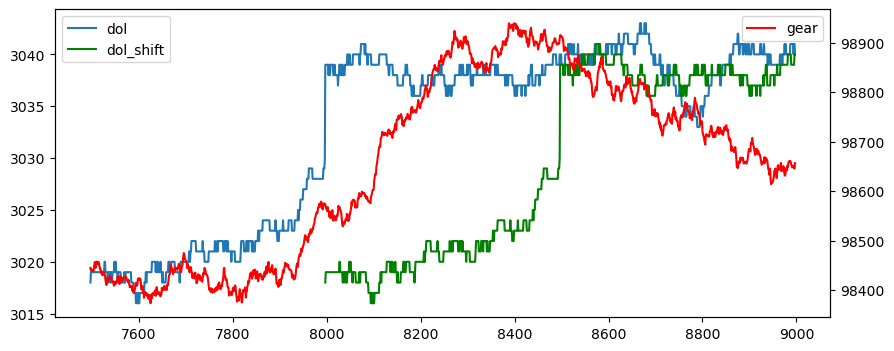

In [26]:
# find good offset
shift = 500

plt.figure(figsize=(10, 4))

ind = 7997
df = pair_df.loc[ind-500:ind+1000].copy()
df["dol_shift"] = df["dol"].shift(shift)

# plot dol/gear over time
ax = plt.gca()
ax.plot(df.index, df["dol"], label="dol")
ax.plot(df.index, df["dol_shift"], color="green", label="dol_shift")

ax2 = ax.twinx()
ax2.plot(df.index, df["gear"], color="red", label="gear")

ax.legend(loc=2)
ax2.legend(loc=1)

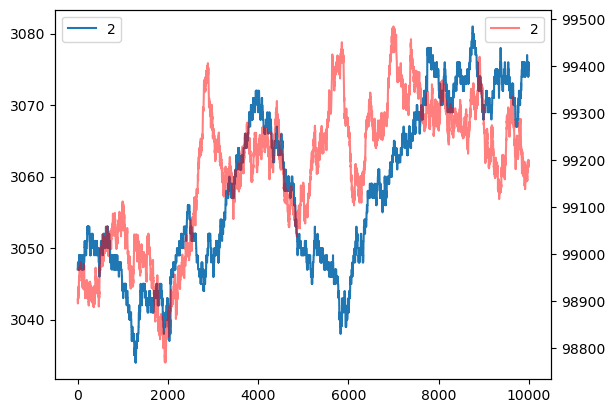

In [27]:
ax = plt.gca()

# ax.plot(np.arange(10000), pair_df["dol"].loc[:10000-1], label=1)
ax.plot(np.arange(10000), pair_df["dol"].loc[10000:20000-1], label=2)
# ax.plot(np.arange(10000), pair_df["dol"].loc[20000:], label=3)

ax2 = ax.twinx()

# ax2.plot(np.arange(10000), pair_df["gear"].loc[:10000-1], label=1, color="red")
ax2.plot(np.arange(10000), pair_df["gear"].loc[10000:20000-1], label=2, color="red", alpha=0.5)
# ax2.plot(np.arange(10000), pair_df["gear"].loc[20000:], label=3, color="red")

ax.legend(loc=2)
ax2.legend(loc=1)


In [28]:
def get_merged_data(x, y):
    inds = x.index.intersection(y.index)
    return x.loc[inds], y.loc[inds]

## past Dol Change -> future Gear change

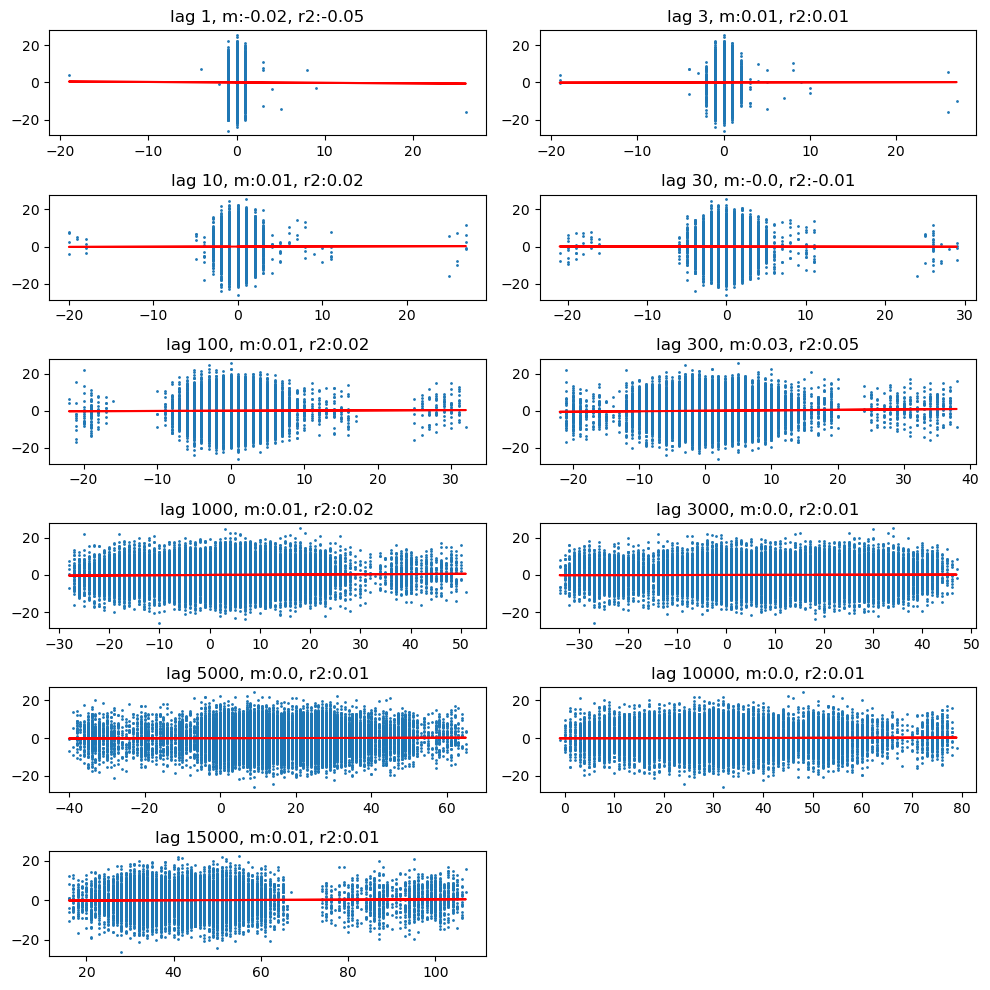

In [30]:
diffs = [1, 3, 10, 30, 100, 300, 1000, 3000, 5000, 10000, 15000]

plt.figure(figsize=(10, 10))

model_data = []

for index, lag in enumerate(diffs):
    x = pair_df["dol"].diff(lag).dropna()
    y = -1 * pair_df["gear"].diff(-1 * 1).dropna()
    x, y = get_merged_data(x, y)

    model = np.poly1d(np.polyfit(x, y, deg=1))
    
    score = round(r2_score(y, model(y)), 2)
    
    model_data += [{
        "m": model.coef[0],
        "b": model.coef[1],
        "r2": score,
    }]
    
    plt.subplot(6, 2, index + 1)
    plt.scatter(x, y, s=1)
    plt.plot(x, model(x), color="red")
    plt.title(f"lag {lag}, m:{round(model.coef[0], 2)}, r2:{score}")
    
plt.tight_layout()
plt.show()

model_df = pd.DataFrame(model_data)

### Lin Reg: dol_cur, gear_cur -> gear_next

In [31]:
from sklearn.linear_model import LinearRegression

In [55]:
pair_df

,time,gear,dol,dol_change,dol_sign,gear_change,gear_next
0,0,100000.0,3000.0,NaN,NaN,NaN,-807.5
1,100,100000.0,3000.0,0.0,0.0,0.0,-801.0
2,200,100002.0,2999.0,-1.0,-1.0,2.0,-806.5
3,300,100000.0,2999.0,0.0,0.0,-2.0,-806.0
4,400,99994.5,2999.0,0.0,0.0,-5.5,-799.5
...,...,...,...,...,...,...,...
29995,2999500,100174.5,3094.0,0.0,0.0,9.5,NaN
29996,2999600,100171.0,3094.0,0.0,0.0,-3.5,NaN
29997,2999700,100179.5,3094.0,0.0,0.0,8.5,NaN
29998,2999800,100182.0,3094.0,0.0,0.0,2.5,NaN


In [94]:
# use current dolphin price and current gear price to predict next gear price

# try_turns = [1, 3, 10, 30, 100, 300, 500]
try_turns = [1000, 1500, 2000, 3000, 5000, 10000, 15000, 20000, 25000]
try_turns = np.arange(1000, 30000, 100)

plt.figure(figsize=(10, 10))

models = []

for ind, forecast_amt in enumerate(try_turns):
    pair_df["gear_next"] = -1 * pair_df["gear"].diff(-1 * forecast_amt)

    # only keep non-nan points
    df = pair_df.dropna()
    X = df[["gear", "dol"]]
    y = df["gear_next"]

    # fit the model and print results
    reg = LinearRegression().fit(X, y)
    print("model", forecast_amt, reg.coef_, reg.intercept_)
    print("r2", reg.score(X, y))
    
    models += [{
        "shift": forecast_amt,
        "w1": reg.coef_[0],
        "w2": reg.coef_[1],
        "b": reg.intercept_,
        "r2": reg.score(X, y),
    }]
    
#     plt.subplot(10, 3, ind+1)
#     plt.plot(y)
#     plt.plot(reg.predict(X))
    
#     plt.title(f"model {forecast_amt}")

# plt.tight_layout()
# plt.show()


model 1000 [-0.29334127  3.30147476] 19073.9520815981
r2 0.18829353726412734
model 1100 [-0.31172961  3.4369794 ] 20488.451623406327
r2 0.19501718311949967
model 1200 [-0.32727518  3.55142167] 21685.011937215466
r2 0.2003493571268734
model 1300 [-0.34210494  3.66043869] 22826.97339031786
r2 0.2056971396947891
model 1400 [-0.35753493  3.80224775] 23928.250187477
r2 0.2130031133524397
model 1500 [-0.37203798  3.93507532] 24964.92869410615
r2 0.21974874703927227
model 1600 [-0.38974232  4.12532035] 26144.12418863313
r2 0.22979237676573727
model 1700 [-0.40903773  4.33062799] 27435.73913972938
r2 0.24014115212674614
model 1800 [-0.42658328  4.50153809] 28658.87367982744
r2 0.24798789000500032
model 1900 [-0.44484747  4.68303626] 29921.01180404614
r2 0.2566304619111507
model 2000 [-0.46320362  4.85154511] 31231.65782499843
r2 0.26488775785732666
model 2100 [-0.48028249  4.99575212] 32489.71046762187
r2 0.2715738658720076
model 2200 [-0.49643897  5.12437257] 33703.51136175263
r2 0.2776071484

model 11800 [-0.97323745 13.97504295] 54414.02597962101
r2 0.7921376573251656
model 11900 [-0.98073597 13.86232668] 55506.864237835616
r2 0.7927003330533753
model 12000 [-0.98620662 13.72521829] 56472.6817757542
r2 0.7929981215562745
model 12100 [-0.99154595 13.65422389] 57224.508266718105
r2 0.7938442862701753
model 12200 [-0.99392894 13.6377533 ] 57517.432895199956
r2 0.7951277483663455
model 12300 [-0.99291845 13.68555366] 57278.24346782716
r2 0.7976758884505497
model 12400 [-0.99335305 13.71742851] 57230.28376263979
r2 0.8006345194478204
model 12500 [-0.99813114 13.72807721] 57677.45902805769
r2 0.8039689066743143
model 12600 [-1.0084585  13.77499952] 58564.62327710453
r2 0.810203556946393
model 12700 [-1.02113555 13.85656116] 59579.148101113016
r2 0.8176350325626105
model 12800 [-1.03732189 13.93864489] 60939.619068356275
r2 0.8247395174743847
model 12900 [-1.06135392 14.06570756] 62940.94704911257
r2 0.8357503048861625
model 13000 [-1.08562093 14.14860339] 65100.14276184862
r2 0.

model 23000 [-1.22273499  2.70007198] 113899.72822233947
r2 0.786586590877443
model 23100 [-1.13624604  3.04802184] 104246.29947166576
r2 0.7290549349540343
model 23200 [-1.05118136  3.36752064] 94819.03059685924
r2 0.684653260305234
model 23300 [-0.96855729  3.80629322] 85272.49061172268
r2 0.6689074619885889
model 23400 [-0.8759689   4.18024124] 74930.29428291637
r2 0.6577865172115352
model 23500 [-0.79344481  4.30120924] 66354.4220762668
r2 0.6311323722384381
model 23600 [-0.66263424  4.47628821] 52809.95571127961
r2 0.5975722141667406
model 23700 [-0.49991374  4.64690312] 36103.85637856004
r2 0.568376229450393
model 23800 [-0.41314056  4.77656562] 27078.042182965663
r2 0.5624713850454374
model 23900 [-0.41731634  4.85688034] 27252.27172989389
r2 0.5648868150067263
model 24000 [-0.45887713  4.88680235] 31298.241135640386
r2 0.5715274138961939
model 24100 [-0.47635145  4.97921929] 32758.989730558762
r2 0.5813359667842033
model 24200 [-0.52362069  4.97964083] 37462.30067733462
r2 0.58

<Figure size 1000x1000 with 0 Axes>

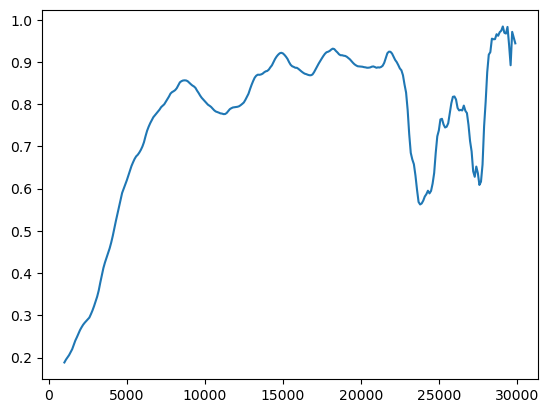

In [98]:
model_df = pd.DataFrame(models)

plt.plot(model_df["shift"], model_df["r2"])

l1_err 163.95881791895357
mse 40060.60446899907


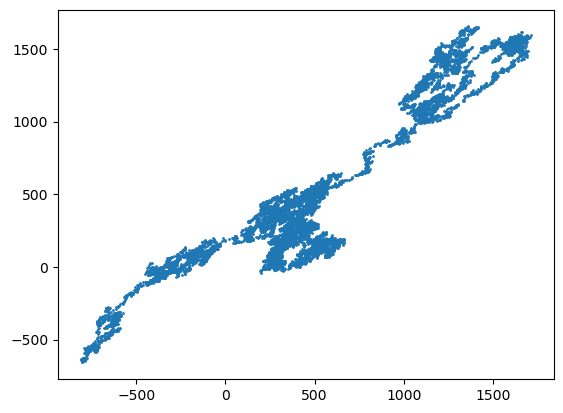

In [35]:
# make results df
res_df = pd.DataFrame({
    "pred": reg.predict(X),
    "y": y,
})

res_df["error"] = res_df["y"] - res_df["pred"]

abs_l1_err = np.mean(res_df["error"].abs())
mse = np.mean(res_df["error"] ** 2)
print("l1_err", abs_l1_err)
print("mse", mse)

# plot results
plt.scatter(res_df["y"], res_df["pred"], s=1)


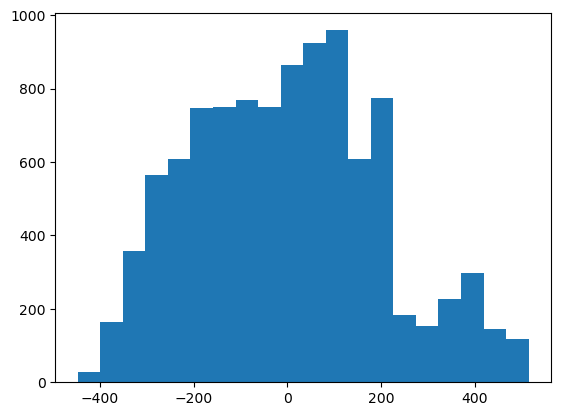

In [39]:
plt.hist(res_df["error"], bins=20)
plt.show()

In [40]:
check_stationary(error)

ADF Statistic: -3.468050
p-value: 0.008847
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### time lagged cross correlation

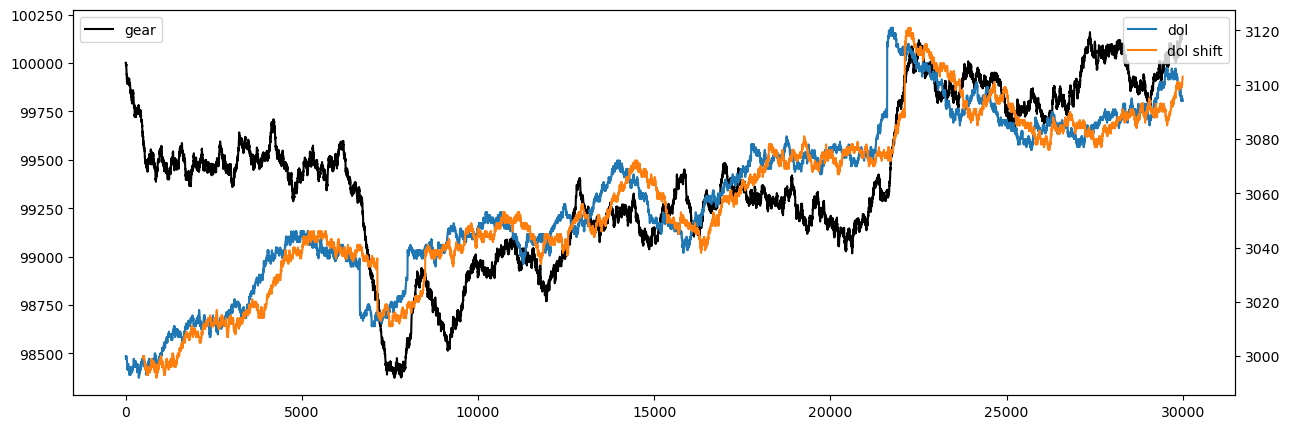

In [69]:
plt.figure(figsize=(15, 5))

ax = plt.gca()
ax.plot(pair_df["gear"], label="gear", color="black")
ax2 = ax.twinx()
ax2.plot(pair_df["dol"], label="dol")
ax2.plot(pair_df["dol"].shift(500), label="dol shift")

ax.legend(loc=2)
ax2.legend(loc=1)


In [71]:
corrs = []

for i in range(0, 30000, 100):
    corr = pair_df["dol"].shift(i).corr(pair_df["gear"])
    corrs += [{
        "lag": i,
        "corr": corr,
    }]
    
df = pd.DataFrame(corrs)


(0.0, 1.0)

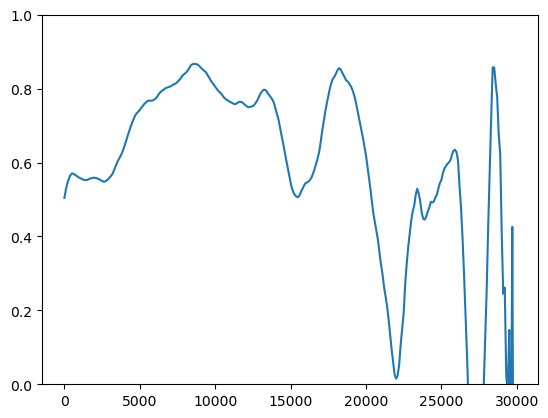

In [73]:
plt.plot(df["lag"], df["corr"])
plt.ylim(0, 1)

In [ ]:
plt.plot(df["corr"])

In [37]:
diffs = pair_df.iloc[5000:10000]["gear"].diff(1)

data = []

chunk_size = 20
for i in range(len(pair_df) // chunk_size):
    lb = i * chunk_size
    ub = lb + chunk_size
    

    data += [{"diff10": np.mean(diffs.loc[lb:ub])}]

In [38]:
models = []
chunk_size = 100

for i in range(len(pair_df) - chunk_size):
    lb = i
    ub = i + chunk_size
    
    df = pair_df["gear"].iloc[lb:ub]
    
    model = np.poly1d(np.polyfit(np.arange(len(df)), df, deg=1))
    models += [{
        "m": model.coef[0],
        "b": model.coef[1],
    }]
    

In [39]:
model_df = pd.DataFrame(models)

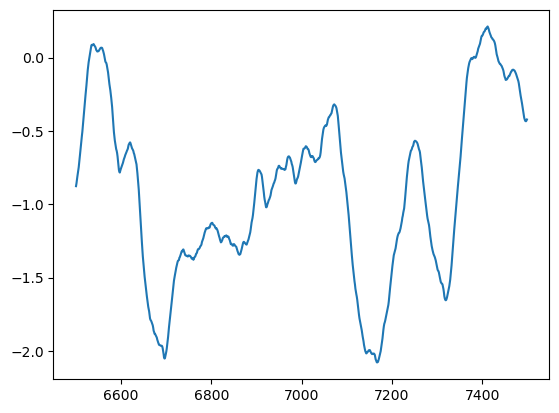

In [40]:
plt.plot(model_df["m"].iloc[6500:7500])

(array([ 2.,  6.,  9.,  9., 15., 17., 28., 35., 29., 26., 34., 13., 12.,
         6.,  4.,  3.,  0.,  0.,  1.,  0.,  1.]),
 array([-3.71428571, -3.27437642, -2.83446712, -2.39455782, -1.95464853,
        -1.51473923, -1.07482993, -0.63492063, -0.19501134,  0.24489796,
         0.68480726,  1.12471655,  1.56462585,  2.00453515,  2.44444444,
         2.88435374,  3.32426304,  3.76417234,  4.20408163,  4.64399093,
         5.08390023,  5.52380952]),
 <BarContainer object of 21 artists>)

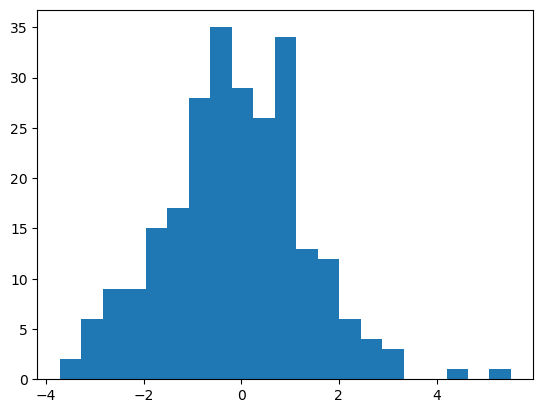

In [41]:
plt.hist(pd.DataFrame(data), bins=21)

(array([   7.,   38.,  107.,  341.,  736., 1428., 2186., 3168., 4403.,
        4463., 4253., 3568., 2452., 1491.,  771.,  369.,  137.,   52.,
          15.,    5.]),
 array([-73.5  , -65.825, -58.15 , -50.475, -42.8  , -35.125, -27.45 ,
        -19.775, -12.1  ,  -4.425,   3.25 ,  10.925,  18.6  ,  26.275,
         33.95 ,  41.625,  49.3  ,  56.975,  64.65 ,  72.325,  80.   ]),
 <BarContainer object of 20 artists>)

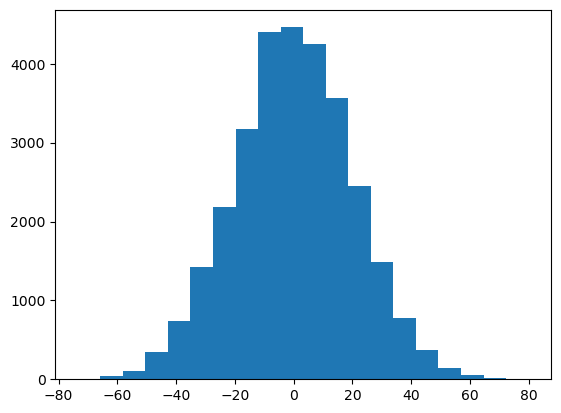

In [42]:
diff10 = pair_df["gear"].diff(10)

plt.hist(diff10, bins=20)

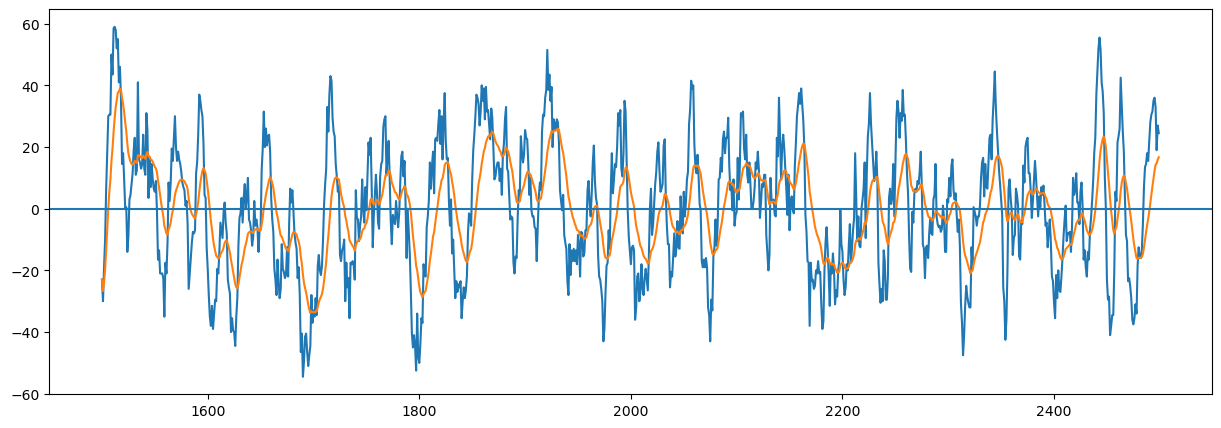

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(diff10.iloc[1500:2500])
plt.plot(diff10.iloc[1500:2500].ewm(span=20).mean())
plt.axhline()

<AxesSubplot:>

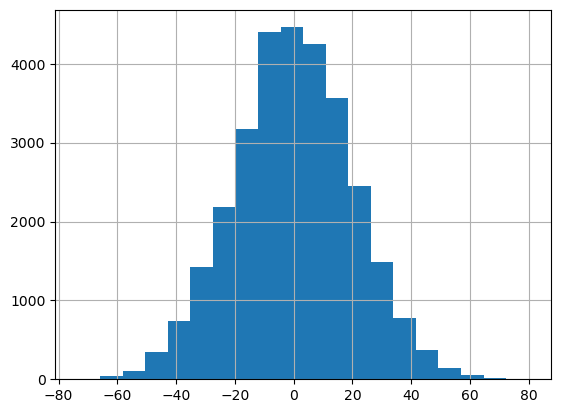

In [44]:
diff10.hist(bins=20)

In [45]:
diffs = 500

X = pair_df[["dol"]].diff(500).dropna()
y = -1 * pair_df["gear"].diff(-1 * 500).dropna()

X, y = get_merged_data(X, y)

reg = LinearRegression().fit(X, y)

In [46]:
reg.score(X, y)

0.1683689206292297

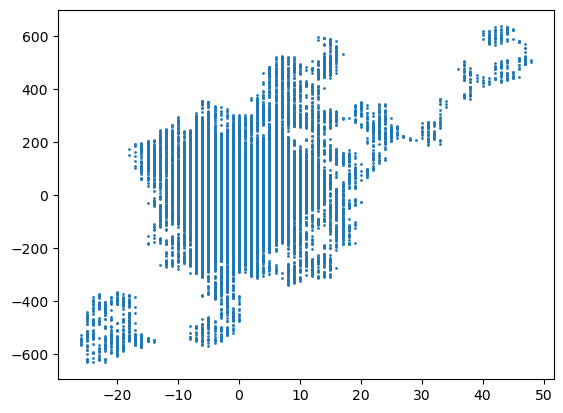

In [47]:
plt.scatter(X, y, s=1)

## berries

In [48]:
berry_df = get_symbol_prices("BERRIES", _day_range)
trade_df = get_symbol_trades("BERRIES", _day_range)
quote_df = get_whale_quotes(berry_df)

trade_df = trade_df.merge(quote_df[["mid_price", "time"]], on="time")


fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/prices_round_3_day_2.csv
fname ../data/round3/trades_round_3_day_0_nn.csv
fname ../data/round3/trades_round_3_day_1_nn.csv
fname ../data/round3/trades_round_3_day_2_nn.csv


In [56]:
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid_price"]

berry_df["take_buy_edge"] = berry_df["buy_price_1"] - berry_df["mid_price"]
berry_df["take_sell_edge"] = berry_df["sell_price_1"] - berry_df["mid_price"]


In [60]:
trade_df[trade_df["sell_edge"] <0]

,time,buyer,seller,symbol,currency,price,quantity,day,mid_price,sell_edge
1,700,NaN,NaN,BERRIES,SEASHELLS,3997.0,11,0,4000.5,-3.5
3,4300,NaN,NaN,BERRIES,SEASHELLS,3998.0,10,0,4001.5,-3.5
4,5400,NaN,NaN,BERRIES,SEASHELLS,4000.0,17,0,4003.5,-3.5
6,7300,NaN,NaN,BERRIES,SEASHELLS,3999.0,5,0,4002.5,-3.5
8,11900,NaN,NaN,BERRIES,SEASHELLS,3993.0,10,0,3996.5,-3.5
...,...,...,...,...,...,...,...,...,...,...
1757,2993500,NaN,NaN,BERRIES,SEASHELLS,3907.0,9,2,3910.5,-3.5
1758,2995800,NaN,NaN,BERRIES,SEASHELLS,3905.0,8,2,3908.5,-3.5
1760,2997200,NaN,NaN,BERRIES,SEASHELLS,3905.0,10,2,3908.5,-3.5
1761,2998500,NaN,NaN,BERRIES,SEASHELLS,3906.0,10,2,3909.5,-3.5


(array([  3.,  11., 664., 102.,   0.,   0.,  19.,  13.,  75.,   0.,  10.,
         25.,   0.,   0.,   0.,   1., 136., 675.,  25.,   5.]),
 array([-4.5 , -4.05, -3.6 , -3.15, -2.7 , -2.25, -1.8 , -1.35, -0.9 ,
        -0.45,  0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,
         3.6 ,  4.05,  4.5 ]),
 <BarContainer object of 20 artists>)

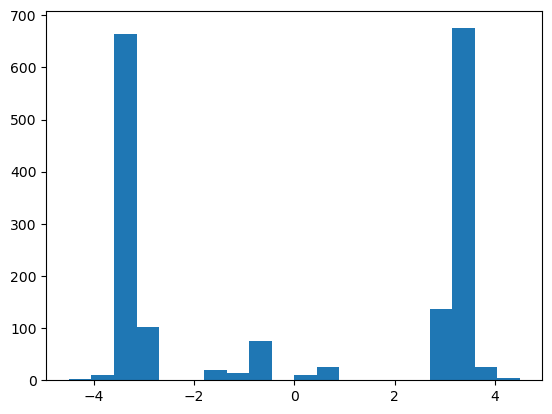

In [57]:
plt.hist(trade_df["sell_edge"], bins=20)

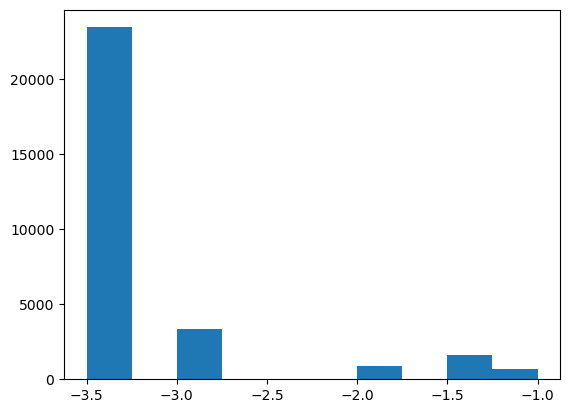

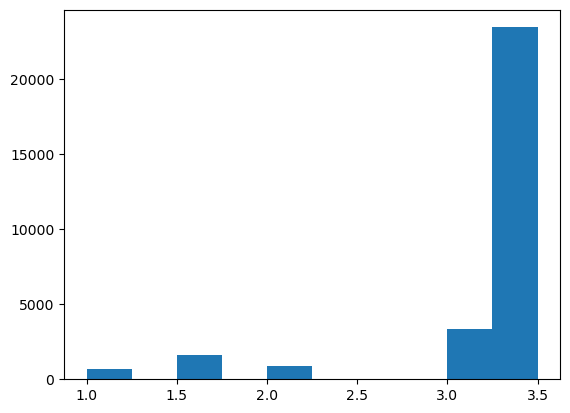

In [58]:
plt.hist(berry_df["take_buy_edge"])
plt.show()

plt.hist(berry_df["take_sell_edge"])
plt.show()

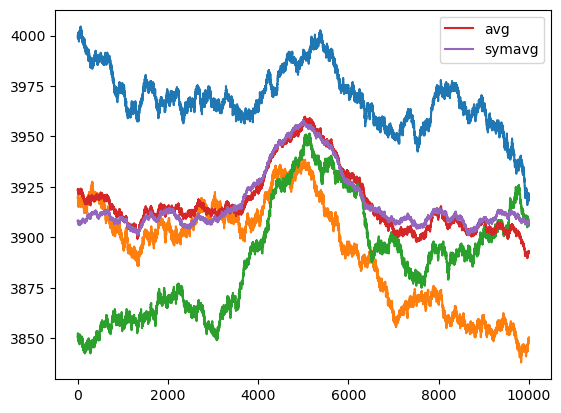

In [98]:
prices = berry_df["mid_price"]

prices = pd.DataFrame({
    "day1": prices.iloc[:10000].values, 
    "day2": prices.iloc[10000:20000].values, 
    "day3": prices.iloc[20000:].values, 
})

prices["cycle_time"] = np.arange(0, 1, 1/len(prices))
prices["avg"] = prices[["day1", "day2", "day3"]].mean(axis=1)
prices["symavg"] = (prices["avg"] + prices["avg"].to_numpy()[::-1]) / 2

plt.plot(prices["day1"])
plt.plot(prices["day2"])
plt.plot(prices["day3"])
plt.plot(prices["avg"], label="avg")
plt.plot(prices["symavg"], label="symavg")

plt.legend()


In [99]:
from scipy.optimize import curve_fit

[3907.02101008   85.43886757   11.31638809   -6.00653777]


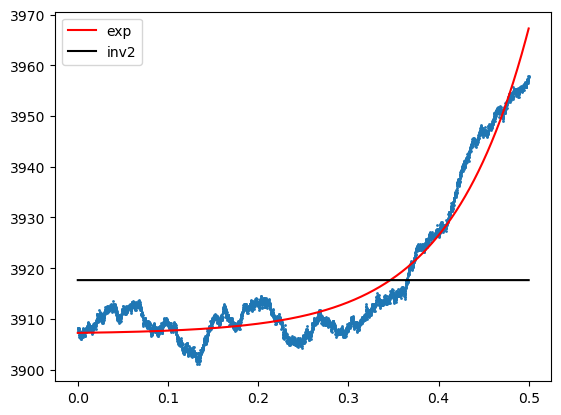

In [141]:
def exp(x, a, b, c, d):
    return a + b * np.exp(c * x + d)

def inv2(x, a, b, c):
    return a / (x + b) ** 2 + c

df = prices.iloc[:5000]

X = df["cycle_time"]
y = df["symavg"].rolling(1).mean().bfill().ffill()

popt1, pcov = curve_fit(exp, X, y, [1, 1, 1, 1])
fit_fn1 = lambda x : exp(x, *popt1)
print(popt1)

# popt2, pcov = curve_fit(inv2, X, y, [1, 1, 1])
# fit_fn2 = lambda x : inv2(x, *popt2)
# print(popt2)

plt.scatter(X, y, s=1)
plt.plot(X, fit_fn1(X), color="red", label="exp")
plt.plot(X, fit_fn2(X), color="black", label="inv2")
plt.legend()

In [159]:
prices[prices["cycle_time"] == 0.3335]

,day1,day2,day3,cycle_time,avg,symavg
3335,3970.5,3912.0,3869.5,0.3335,3917.333333,3914.666667


In [144]:
prices[prices["cycle_time"] == 0.5]

,day1,day2,day3,cycle_time,avg,symavg
5000,3992.5,3937.5,3943.5,0.5,3957.833333,3957.666667


In [82]:
model

poly1d([ 458.83115892, -149.90344189, 3916.88017207])

In [54]:
prices

,day1,day2,day3,avg,symavg
0,4000.0,3919.5,3850.5,3923.333333,3908.250000
1,3999.5,3919.5,3850.5,3923.166667,3907.583333
2,3998.5,3919.5,3852.5,3923.500000,3908.166667
3,3998.5,3919.5,3851.5,3923.166667,3908.166667
4,3999.5,3920.5,3852.0,3924.000000,3908.000000
...,...,...,...,...,...
9995,3920.5,3850.0,3905.5,3892.000000,3908.000000
9996,3922.0,3850.0,3907.5,3893.166667,3908.166667
9997,3920.5,3850.5,3907.5,3892.833333,3908.166667
9998,3918.0,3850.5,3907.5,3892.000000,3907.583333


(array([ 14., 766.,   0.,  32.,  75.,  35.,   0.,   1., 811.,  30.]),
 array([-4.5, -3.6, -2.7, -1.8, -0.9,  0. ,  0.9,  1.8,  2.7,  3.6,  4.5]),
 <BarContainer object of 10 artists>)

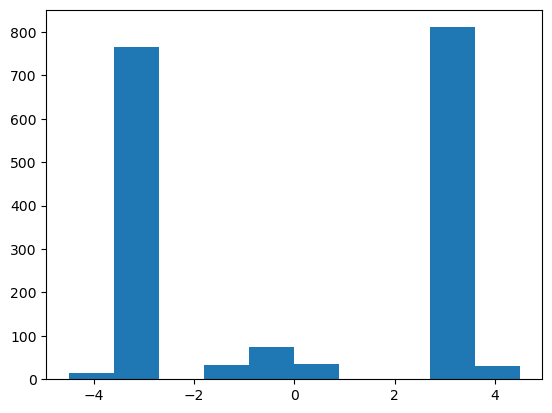

In [55]:
plt.hist(trade_df["sell_edge"])